In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from SI_Classes import SI_model, DataScaler, LinearizedModel
from System_Classes import CascadedTankSystem, LTISystem, WHSystem, CascadedTankSystem_Simplified, CSTR_MISO_2by1
from SI_Functions import generate_step_signals, rNMPC
# Set seed for reproducibility
seed=42
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# True system
dt = 0.05
sys = CSTR_MISO_2by1(dt=dt, add_noise=False, noise_magnitude=0)
x0_denorm = sys.x0

In [3]:
n_x = sys.n_x
n_u = sys.n_u
n_y = sys.n_y

t_fit  = np.array([0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180]) * dt
t_test = np.array([0, 15, 30, 45, 60, 75, 90]) * dt
w_fit  = np.array([[12, 8, 12, 16, 13, 7, 9, 15, 11, 9, 11, 12],
                  [292, 300, 310, 295, 306, 308, 300, 296, 292, 290, 295, 300]]).T
w_test = np.array([[13, 5, 16, 7, 14, 8],
                  [294, 301, 310, 295, 304, 302]]).T

time_steps_fit_denorm, u_fit_denorm   = generate_step_signals(t_segments_list=t_fit, w_values=w_fit, n_u=n_u, dt=dt)
time_steps_test_denorm, u_test_denorm = generate_step_signals(t_segments_list=t_test, w_values=w_test, n_u=n_u, dt=dt)

y_fit_true_denorm,  x_fit_true_denorm  = sys(u_fit_denorm, x0_denorm)
y_test_true_denorm, x_test_true_denorm = sys(u_test_denorm, x0_denorm)

In [4]:
datascaler = DataScaler(
    mu_u=np.mean(u_fit_denorm, axis=0),
    mu_y=np.mean(y_fit_true_denorm, axis=0), 
    mu_x=np.mean(x_fit_true_denorm, axis=0),
    std_u=np.std(u_fit_denorm, axis=0),
    std_y=np.std(y_fit_true_denorm, axis=0), 
    std_x=np.std(x_fit_true_denorm, axis=0),
    mu_offset_u=0*np.mean(u_fit_denorm, axis=0),
    mu_offset_y=0*np.mean(y_fit_true_denorm, axis=0), 
    mu_offset_x=0*np.mean(x_fit_true_denorm, axis=0),  
    )

# Normalizing the Data
u_fit       = datascaler.normalize(u_fit_denorm, datascaler.mu_u, datascaler.std_u, datascaler.mu_offset_u)
u_test      = datascaler.normalize(u_test_denorm, datascaler.mu_u, datascaler.std_u, datascaler.mu_offset_u)
y_fit_true  = datascaler.normalize(y_fit_true_denorm, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
y_test_true = datascaler.normalize(y_test_true_denorm, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
x0          = datascaler.normalize(x0_denorm, datascaler.mu_x, datascaler.std_x, datascaler.mu_offset_x)

# Signals for Counter-Factual Argument
t_fit_cf       = np.copy(t_fit)
u_fit_cf       = np.copy(u_fit)
y_fit_true_cf  = np.copy(y_fit_true)
u_test_cf      = np.copy(u_test)
y_test_true_cf = np.copy(y_test_true)

In [5]:
# Setup neural model structure
hidden_size         = 16
tau_prior           = 0.05
sigma_noise         = 5e-2
nn_fit_iters_base   = 200
nn_fit_lr_base      = 1e-2

In [6]:
from NN_Classes import f_ss_class, f_ss_diag_class, NeuralStateUpdate
class custom_g_class(nn.Module):
    def __init__(self, n_x, n_y, hidden_size=None):
        super(custom_g_class, self).__init__()
        self.n_x = n_x
        self.n_y = n_y
        C = torch.zeros((n_y, n_x), dtype=torch.float32)
        C[0, 0] = 1
        self.C = nn.Parameter(C)
    def forward(self, x):
        if x.ndim > 1:
            T = x.shape[0]
            y = torch.zeros((T, self.n_y))
            for k in range(T):
                y[k, :] = self.C @ x[k, :]
            return y
        else:
            x_step = x
            y_step = self.C @ x_step
            return y_step

si_model = SI_model(n_x, n_u, n_y, hidden_size, dtype=torch.float32, device=torch.device("cpu"), tau_prior=tau_prior, sigma_noise=sigma_noise, modify_si=False, f_class=NeuralStateUpdate, g_class=custom_g_class)
y_fitted, x_fitted, loss_fit = si_model.nn_fit(u_fit=u_fit , y_fit=y_fit_true, x0=x0, num_iter=nn_fit_iters_base, lr=nn_fit_lr_base, print_freq=25, return_loss=True)
y_test, _      = si_model.nn_predict(u_pred=u_test, x0_pred=x0)
loss_test = np.mean((y_test - y_test_true)**2)
print(f"Prediction Loss {loss_test:.4f}")

Iter 0 | Fit Loss 2.0732
Iter 25 | Fit Loss 0.1229
Iter 50 | Fit Loss 0.0177
Iter 75 | Fit Loss 0.0121
Iter 100 | Fit Loss 0.0042
Iter 125 | Fit Loss 0.0028
Iter 150 | Fit Loss 0.0022
Iter 175 | Fit Loss 0.0016
Iter 199 | Fit Loss 0.0012
Prediction Loss 0.0063


In [7]:
n_samples = 4
lin_freq  = 2
apply_res_corr_x = True
apply_res_corr_y = True
update_res_corr_x  = True
update_res_corr_y  = True
_, _, _, _, _, _, _, _ = si_model.compute_fit_cov(u_fit=u_fit, x0_fit=x0)
sample_model_dict = si_model.sample(n_samples)

y_fitted_sample_dict  = {}
y_test_sample_dict    = {}

sample_lin_model_dict = {}
y_fitted_lin_sample_dict  = {}
y_test_lin_sample_dict    = {}

for sample_idx in range(n_samples):
    y_fitted_sample_dict[sample_idx] = sample_model_dict[sample_idx](x_0=torch.tensor(x0, dtype=torch.float32), u=torch.tensor(u_fit, dtype=torch.float32), return_x=False).detach().numpy()
    y_test_sample_dict[sample_idx]   = sample_model_dict[sample_idx](x_0=torch.tensor(x0, dtype=torch.float32), u=torch.tensor(u_test, dtype=torch.float32), return_x=False).detach().numpy()

    sample_lin_model_dict[sample_idx]       = LinearizedModel(model=sample_model_dict[sample_idx], n_x=n_x, n_u=n_u, n_y=n_y)
    y_test_lin_sample_dict[sample_idx], _   = sample_lin_model_dict[sample_idx](u=u_test, x0=x0, lin_freq=lin_freq, apply_res_corr_x=apply_res_corr_x, apply_res_corr_y=apply_res_corr_y, update_res_corr_x=update_res_corr_x, update_res_corr_y=update_res_corr_y)
    y_fitted_lin_sample_dict[sample_idx], _ = sample_lin_model_dict[sample_idx](u=u_fit,  x0=x0, lin_freq=lin_freq, apply_res_corr_x=apply_res_corr_x, apply_res_corr_y=apply_res_corr_y, update_res_corr_x=update_res_corr_x, update_res_corr_y=update_res_corr_y)

lin_model  = LinearizedModel(model=si_model.model, n_x=si_model.n_x, n_u=si_model.n_u, n_y=si_model.n_y)
y_test_lin, x_test_lin = lin_model(u=u_test, x0=x0, lin_freq=lin_freq, apply_res_corr_x=apply_res_corr_x, apply_res_corr_y=apply_res_corr_y, update_res_corr_x=update_res_corr_x, update_res_corr_y=update_res_corr_y)
y_fitted_lin, x_fitted_lin = lin_model(u=u_fit, x0=x0, lin_freq=lin_freq, apply_res_corr_x=apply_res_corr_x, apply_res_corr_y=apply_res_corr_y, update_res_corr_x=update_res_corr_x, update_res_corr_y=update_res_corr_y)

In [8]:
simulation_length = 6.05
T_sim = int(simulation_length/dt)
y_ref_trajectory_denorm = np.zeros((T_sim, n_y))
y_ref_trajectory_denorm[0:int(T_sim/2), 0]     = 10
y_ref_trajectory_denorm[int(T_sim/2):T_sim, 0] = 11

sampling_interval = dt * 1
Wy   = 10 * np.eye(n_y)
Wu   = 0.1 * np.eye(n_u)

Wunc = 0.1 * np.eye(n_y)

Np = 10
K_I_C_A   = 0
K_I_T     = 0
unc_index_w = 1
w_rand_ws = 0
w_rand    = 0

noise_magnitude = 0.05

# method = "trust-constr"
# method='COBYLA'
method='SLSQP'

warm_start = False
warm_start_method = None

# warm_start = True
# warm_start_method='SLSQP'
# warm_start_method = "trust-constr"
# warm_start_method='Powell'
# warm_start_method='BFGS'
# warm_start_method='Nelder-Mead'

# u_min_denorm           = 10 * np.ones((1, n_u))
# u_max_denorm           = 20 * np.ones((1, n_u))
# x_min_denorm           = -5 * np.ones((1, n_x))
# x_max_denorm           = 5 * np.ones((1, n_x))
# y_min_denorm           = -5 * np.ones((1, n_y))
# y_max_denorm           = 5 * np.ones((1, n_y))
# ppd_std_max_denorm     = 0.05 * np.ones((1,n_y))
# unc_index_norm_max = 15

u_min_denorm           = None
u_max_denorm           = None
x_min_denorm           = None
x_max_denorm           = None
y_min_denorm           = None
y_max_denorm           = None
ppd_std_max_denorm     = None
unc_index_norm_max     = None

In [9]:
y_ref_trajectory  = datascaler.normalize(y_ref_trajectory_denorm, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
u_min = datascaler.normalize(u_min_denorm, datascaler.mu_u, datascaler.std_u, datascaler.mu_offset_u) 
u_max = datascaler.normalize(u_max_denorm, datascaler.mu_u, datascaler.std_u, datascaler.mu_offset_u) 
x_min = datascaler.normalize(x_min_denorm, datascaler.mu_x, datascaler.std_x, datascaler.mu_offset_x) 
x_max = datascaler.normalize(x_max_denorm, datascaler.mu_x, datascaler.std_x, datascaler.mu_offset_x) 
y_min = datascaler.normalize(y_min_denorm, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y) 
y_max = datascaler.normalize(y_max_denorm, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
if ppd_std_max_denorm is not None:
    ppd_std_max = ppd_std_max_denorm/datascaler.std_y
else:
    ppd_std_max = None

Input is None -> Returing None
Input is None -> Returing None
Input is None -> Returing None
Input is None -> Returing None
Input is None -> Returing None
Input is None -> Returing None


In [10]:
# Control Loop
x_cl         = np.zeros((T_sim, n_x))
u_cl         = np.zeros((T_sim, n_u))
y_cl         = np.zeros((T_sim, n_y))
x_cl_nominal = np.zeros((T_sim, n_x))
u_cl_nominal = np.zeros((T_sim, n_u))
y_cl_nominal = np.zeros((T_sim, n_y))
ppd_std_cl_nominal  = np.zeros((T_sim, n_y))
unc_index_norm_nominal = np.zeros(T_sim)
x_cl[0, :]   = x0
u_cl[0, :]   = np.zeros(n_u)
y_cl[0, :]   = x0[0]
x_cl_nominal[0, :] = x_cl[0, :]
u_cl_nominal[0, :] = u_cl[0, :]
y_cl_nominal[0, :] = y_cl[0, :]
u_mpc = np.zeros((Np, n_u))
e_int = 0
Np_rh = Np

# for ind in range(T_sim - Np_rh*int(sampling_interval/dt)):
for ind in range(T_sim):
    if ind + Np_rh*int(sampling_interval/dt) > T_sim-1:
        Np_rh = Np_rh - 1
        if Np_rh == 1:
            print("Prediction Horizon is 1 -> Simulation is terminated")
            break

    e_int = e_int + (y_ref_trajectory[ind, :] - y_cl[ind, :])
    u0=u_mpc[:Np_rh*int(sampling_interval/dt), :]

    if ind % int(sampling_interval/dt) == 0:
        y_mpc, u_mpc, x_mpc, info, ppd_std_mpc, unc_index_norm_mpc = rNMPC(si_model=si_model,
                                        y_ref=y_ref_trajectory[ind: ind + Np_rh*int(sampling_interval/dt)+1, :],
                                        x0=x_cl[ind, :],
                                        u0=u0,
                                        Wy=Wy, Wu=Wu, Wunc=Wunc,
                                        Np_rh=Np_rh,
                                        dt=dt,
                                        sampling_interval=sampling_interval,
                                        u_min=u_min, u_max=u_max, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,
                                        ppd_std_max=ppd_std_max, unc_index_norm_max=unc_index_norm_max, unc_index_w=unc_index_w,
                                        method=method,
                                        warm_start=warm_start, warm_start_method=warm_start_method, apply_warm_start_constraints=False,
                                        ig_w_rand=w_rand, ig_warm_start_w_rand=w_rand_ws)
    

    print(f"index: #{ind} || Solver Status: {info} || Prediction Horizon: {Np_rh}")
    if info == 'Solver failed to converge':
        break

    x_cl_nominal[ind+1, :] = x_mpc[1, :]
    u_cl_nominal[ind, :]   = u_mpc[0, :]
    y_cl_nominal[ind+1, :] = y_mpc[1, :]
    ppd_std_cl_nominal[ind+1, :] = ppd_std_mpc[1, :]
    unc_index_norm_nominal[ind+1] = unc_index_norm_mpc
    
    # u_cl[ind, :] = u_mpc[0, :]

    u_cl[ind, 0] = u_mpc[0, 0] + K_I_C_A * e_int[0]
    u_cl[ind, 1] = u_mpc[0, 1] + K_I_T   * e_int[0]

    u_cl_denorm_ind = datascaler.denormalize(u_cl[ind, :], datascaler.mu_u, datascaler.std_u, datascaler.mu_offset_u)
    x_cl_denorm_ind = datascaler.denormalize(x_cl[ind, :], datascaler.mu_x, datascaler.std_x, datascaler.mu_offset_x)
    y_cl_denorm_ind_updated, x_cl_denorm_ind_updated = sys.update(u=u_cl_denorm_ind, x=x_cl_denorm_ind)

    y_cl_denorm_ind_updated = y_cl_denorm_ind_updated + noise_magnitude * np.random.randn(n_y)

    x_cl[ind + 1, :] = datascaler.normalize(x_cl_denorm_ind_updated, datascaler.mu_x, datascaler.std_x, datascaler.mu_offset_x)
    y_cl[ind + 1, :] = datascaler.normalize(y_cl_denorm_ind_updated, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
    

index: #0 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #1 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #2 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #3 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #4 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #5 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #6 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #7 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #8 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #9 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #10 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #11 || Solver Status: Solver converged successfully || Prediction Ho

In [11]:
# CounterFactual Argument
Wunc_cf = 0 * np.eye(n_y)
# Counterfactual Control Loop
x_cl_cf         = np.zeros((T_sim, n_x))
u_cl_cf         = np.zeros((T_sim, n_u))
y_cl_cf         = np.zeros((T_sim, n_y))
x_cl_nominal_cf = np.zeros((T_sim, n_x))
u_cl_nominal_cf = np.zeros((T_sim, n_u))
y_cl_nominal_cf = np.zeros((T_sim, n_y))
ppd_std_cl_nominal_cf  = np.zeros((T_sim, n_y))
unc_index_norm_nominal_cf = np.zeros(T_sim)
x_cl_cf[0, :]   = x0
u_cl_cf[0, :]   = np.zeros(n_u)
y_cl_cf[0, :]   = x0[0]
x_cl_nominal_cf[0, :] = x_cl_cf[0, :]
u_cl_nominal_cf[0, :] = u_cl_cf[0, :]
y_cl_nominal_cf[0, :] = y_cl_cf[0, :]
u_mpc_cf = np.zeros((Np, n_u))
e_int_cf = 0
Np_rh = Np

# for ind in range(T_sim - Np_rh*int(sampling_interval/dt)):
for ind in range(T_sim):
    if ind + Np_rh*int(sampling_interval/dt) > T_sim-1:
        Np_rh = Np_rh - 1
        if Np_rh == 1:
            print("Prediction Horizon is 1 -> Simulation is terminated")
            break

    e_int_cf = e_int_cf + (y_ref_trajectory[ind, :] - y_cl[ind, :])
    u0_cf=u_mpc_cf[:Np_rh*int(sampling_interval/dt), :]

    if ind % int(sampling_interval/dt) == 0:
        y_mpc_cf, u_mpc_cf, x_mpc_cf, info_cf, ppd_std_mpc_cf, unc_index_norm_mpc_cf = rNMPC(si_model=si_model,
                                        y_ref=y_ref_trajectory[ind: ind + Np_rh*int(sampling_interval/dt)+1, :],
                                        x0=x_cl_cf[ind, :],
                                        u0=u0_cf,
                                        Wy=Wy, Wu=Wu, Wunc=Wunc_cf,
                                        Np_rh=Np_rh,
                                        dt=dt,
                                        sampling_interval=sampling_interval,
                                        u_min=u_min, u_max=u_max, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,
                                        ppd_std_max=ppd_std_max, unc_index_norm_max=unc_index_norm_max, unc_index_w=unc_index_w,
                                        method=method,
                                        warm_start=warm_start, warm_start_method=warm_start_method, apply_warm_start_constraints=False,
                                        ig_w_rand=w_rand, ig_warm_start_w_rand=w_rand_ws)
    

    print(f"index: #{ind} || Solver Status: {info} || Prediction Horizon: {Np_rh}")
    if info == 'Solver failed to converge':
        break

    x_cl_nominal_cf[ind+1, :] = x_mpc_cf[1, :]
    u_cl_nominal_cf[ind, :]   = u_mpc_cf[0, :]
    y_cl_nominal_cf[ind+1, :] = y_mpc_cf[1, :]
    ppd_std_cl_nominal_cf[ind+1, :] = ppd_std_mpc_cf[1, :]
    unc_index_norm_nominal_cf[ind+1] = unc_index_norm_mpc_cf

    u_cl_cf[ind, 0] = u_mpc_cf[0, 0] + K_I_C_A * e_int_cf[0]
    u_cl_cf[ind, 1] = u_mpc_cf[0, 1] + K_I_T   * e_int_cf[0]

    u_cl_denorm_ind_cf = datascaler.denormalize(u_cl_cf[ind, :], datascaler.mu_u, datascaler.std_u, datascaler.mu_offset_u)
    x_cl_denorm_ind_cf = datascaler.denormalize(x_cl_cf[ind, :], datascaler.mu_x, datascaler.std_x, datascaler.mu_offset_x)
    y_cl_denorm_ind_updated_cf, x_cl_denorm_ind_updated_cf = sys.update(u=u_cl_denorm_ind_cf, x=x_cl_denorm_ind_cf)

    y_cl_denorm_ind_updated_cf = y_cl_denorm_ind_updated_cf + noise_magnitude * np.random.randn(n_y)

    x_cl_cf[ind + 1, :] = datascaler.normalize(x_cl_denorm_ind_updated_cf, datascaler.mu_x, datascaler.std_x, datascaler.mu_offset_x)
    y_cl_cf[ind + 1, :] = datascaler.normalize(y_cl_denorm_ind_updated_cf, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
    

index: #0 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #1 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #2 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #3 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #4 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #5 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #6 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #7 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #8 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #9 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #10 || Solver Status: Solver converged successfully || Prediction Horizon: 10
index: #11 || Solver Status: Solver converged successfully || Prediction Ho

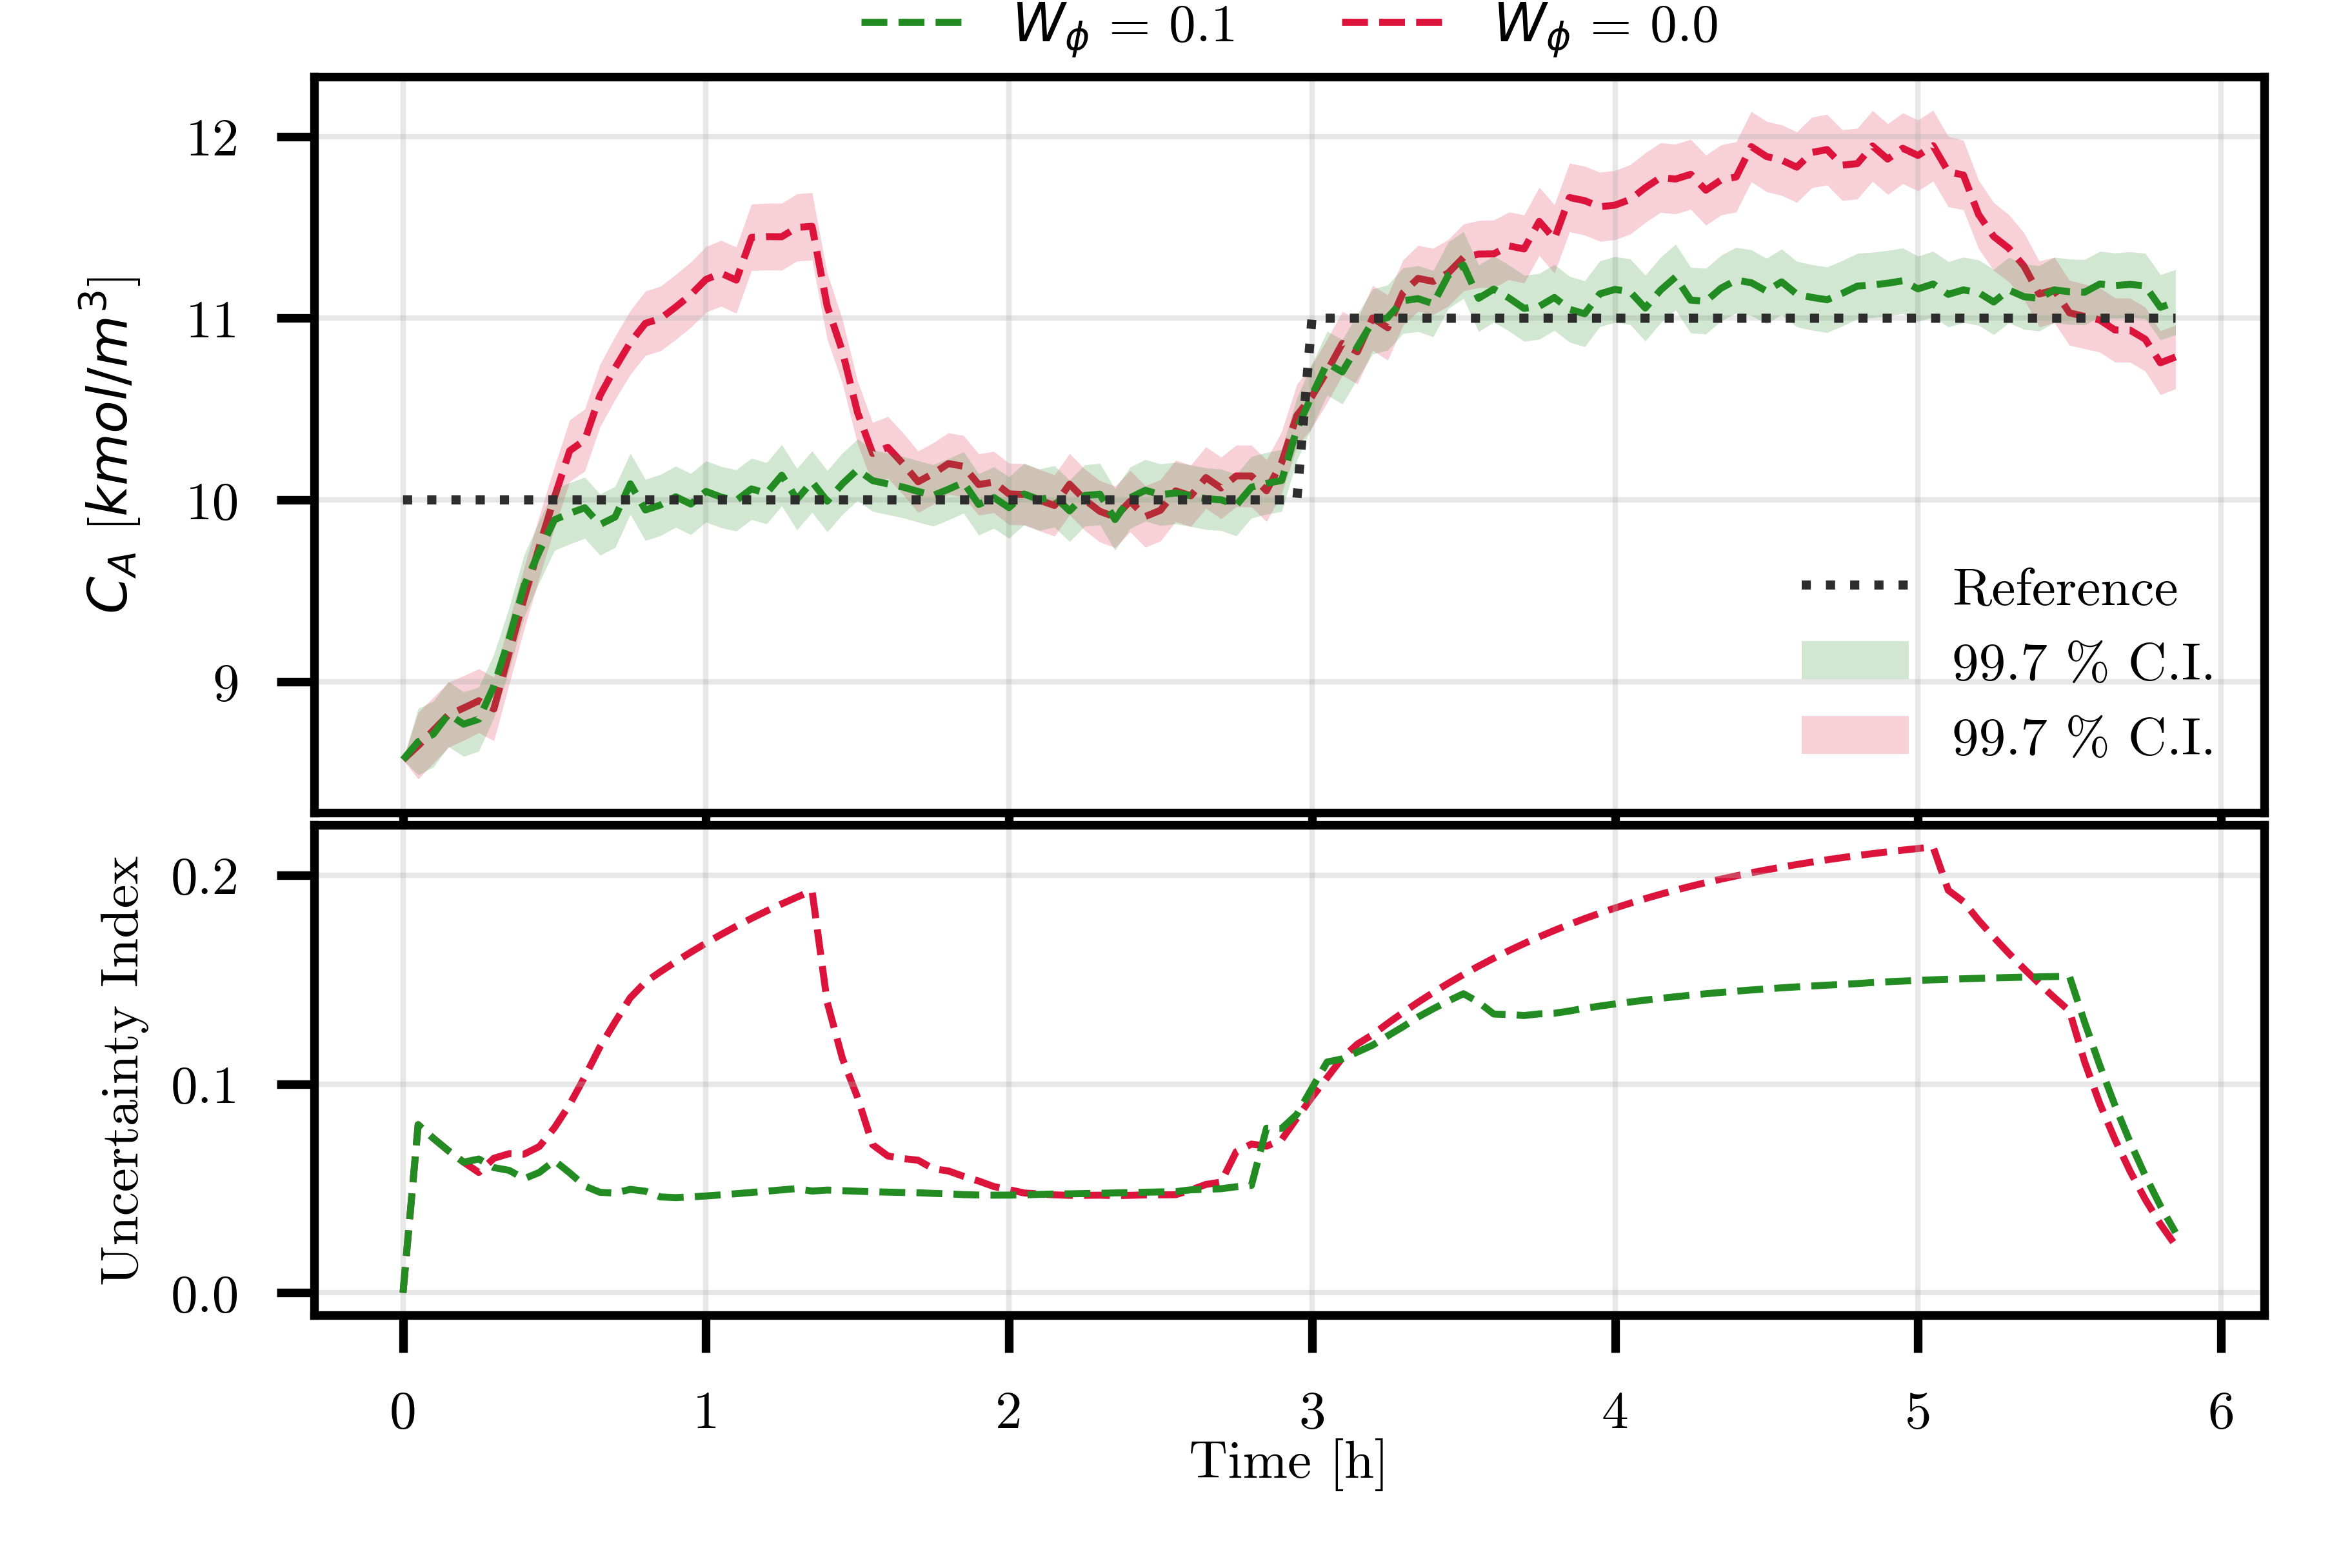

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
colors = ["#2D2D2D", "#1F77B4", "#228B22", "salmon", "#6A0DAD", "#8AA7C1", "crimson"]
# Your existing setup code
t_excess = T_sim - ind
fs = 5
plt.rcParams.update({
    'font.size': fs,            # Set font size globally
    'font.family': 'cmr10',     # Use a serif font (LaTeX-like)
    'legend.fontsize': fs       # Ensure legend follows the font size
})
lw = 0.65
dpi = 1200
time = np.arange(T_sim*dt, step=dt)
time = time[:-t_excess]
ppd_std_multiplier = 3

# Denormalization of variables
ppd_std_cl_nominal_denorm = ppd_std_cl_nominal * datascaler.std_y
y_cl_nominal_denorm = datascaler.denormalize(y_cl_nominal, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
y_cl_denorm = datascaler.denormalize(y_cl, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)

ppd_std_cl_nominal_denorm_cf = ppd_std_cl_nominal_cf * datascaler.std_y
y_cl_nominal_denorm_cf = datascaler.denormalize(y_cl_nominal_cf, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
y_cl_denorm_cf = datascaler.denormalize(y_cl_cf, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)

# Create figure and subplots
fig = plt.figure(figsize=(3.25, 2.5), dpi=dpi)
gs = gridspec.GridSpec(2, 1, height_ratios=[1.5, 1])  # First subplot taller than second
ax1 = plt.subplot(gs[0])  # First subplot (taller)
ax4 = plt.subplot(gs[1], sharex=ax1)  # Second subplot (shorter)

# Plotting on ax1
line_ref = ax1.plot(time, y_ref_trajectory_denorm[:-t_excess, :], label="Ref.", linewidth=lw+0.2, linestyle=':', color=colors[0], zorder=5)
line = ax1.plot(time, y_cl_denorm[:-t_excess, :], label=r"$W_{\phi}$ = " + f"{Wunc[0,0]}", linestyle='--', linewidth=lw, color=colors[2], zorder=4)
line_cf = ax1.plot(time, y_cl_denorm_cf[:-t_excess, :], label=r"$W_{\phi}$ = " + f"{Wunc_cf[0,0]}", linestyle='--', linewidth=lw, color=colors[-1], zorder=2)
line_unc = ax1.fill_between(time,  y_cl_denorm[:-t_excess, :].ravel() - ppd_std_multiplier * ppd_std_cl_nominal_denorm[:-t_excess, :].ravel(),
                 y_cl_denorm[:-t_excess, :].ravel() + ppd_std_multiplier * ppd_std_cl_nominal_denorm[:-t_excess, :].ravel(),
                 color=colors[2], alpha=0.2, label=r"99.7 % C.I.", linewidth=0, zorder=3)
line_unc_cf = ax1.fill_between(time,  y_cl_denorm_cf[:-t_excess, :].ravel() - ppd_std_multiplier * ppd_std_cl_nominal_denorm_cf[:-t_excess, :].ravel(),
                 y_cl_denorm_cf[:-t_excess, :].ravel() + ppd_std_multiplier * ppd_std_cl_nominal_denorm_cf[:-t_excess, :].ravel(),
                 color=colors[-1], alpha=0.2, label=r"99.7 % C.I.", linewidth=0, zorder=1)

ax1.set_ylabel(r"$C_A$ [$kmol/m^3$]", labelpad=4)

# Legends
leg_1 = ax1.legend([line[0], line_cf[0]], [r"$W_{\phi}$ = " + f"{Wunc[0,0]}", r"$W_{\phi}$ = " + f"{Wunc_cf[0,0]}"],  
    loc='upper center', bbox_to_anchor=(0.5, 1.17), ncol=2, fontsize=fs, frameon=False)
ax1.add_artist(leg_1)
leg_2 = ax1.legend([line_ref[0], line_unc, line_unc_cf], ["Reference", r"99.7 % C.I.", r"99.7 % C.I."], loc='lower right', ncol=1, frameon=False)

ax1.grid(True, alpha=0.3, linewidth=0.5)

# Plotting on ax4 (second subplot)
ax4.plot(time, unc_index_norm_nominal[:-t_excess], label=r"$W_{\phi}$ = " + f"{Wunc[0,0]}", linewidth=lw, linestyle='--', color=colors[2], zorder=2)
ax4.plot(time, unc_index_norm_nominal_cf[:-t_excess], label=r"$W_{\phi}$ = " + f"{Wunc_cf[0,0]}", linewidth=lw, linestyle='--', color=colors[-1], zorder=1)

ax4.set_ylabel("Uncertainty Index", labelpad=2)
ax4.set_xlabel("Time [h]", labelpad=0)
ax4.grid(True, alpha=0.3, linewidth=0.5)

# Adjust layout
plt.subplots_adjust(hspace=0.02)  # Adjust the space between subplots
plt.subplots_adjust(top=0.75)

plt.savefig("CSTReactor_MultiRef_Output_plot.pdf", dpi=dpi, bbox_inches='tight')
